# Сказание о золоте и EM-алгоритме

Недавно меня попросили показать простейший пример [EM-алгоритма](https://ru.wikipedia.org/wiki/EM-алгоритм). Недолго думая, я накодил нижеследующее. 

EM - это алгоритм, используемый для нахождения оценок максимального правдоподобия параметров вероятностных моделей, когда модель зависит от скрытых переменных. То есть это такая прокачанная версия метода максимального правдоподобия, которая отлично работает, например, в задачах кластеризации и разделения смеси распределений. 

Что это за задачи такие? Представим, например, что мы ищем в пустыне золото. Мы знаем, что есть два его месторождения, и что крупицы золота распространяются вокруг месторождения со стандартным отклонением в 3 км. Нанеся все найденные крупицы на карту, мы получим не очень внятное облако точек. Как по нему найти координаты месторождений?

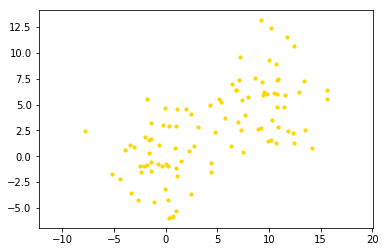

In [1]:
    import numpy as np
    import matplotlib.pyplot as plt
    np.random.seed(42)
    X = np.random.normal(size=(100,2), scale=3)
    X[50:] += (10, 5)
    plt.scatter(X[:,0], X[:,1], s=10, c='gold')
    plt.axis('equal')
    plt.show();

Если бы мы знали, из какого месторождения прилетела каждая крупица, мы бы могли найти его координату как среднее арифметическое из всех крупиц. Если бы мы знали координаты месторождений, мы бы могли сказать, с какой вероятностью крупица прилетела из каждого из них (сравнив плотности нормальный распределений). EM-алгоритм начинает со случайных координат центров месторождений, и перемещает их, поочерёдно обновляя оценки вероятностей и координат центров. Удивительно, но это работает, и тому даже есть строгое [математическое обоснование](https://en.wikipedia.org/wiki/Expectation–maximization_algorithm#Proof_of_correctness)!

In [2]:
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import multivariate_normal

    class FixedCovMixture:
        """ The model to estimate gaussian mixture with fixed covariance matrix. """
        def __init__(self, n_components, cov, max_iter=100, random_state=None, tol=1e-10):
            self.n_components = n_components
            self.cov = cov
            self.random_state = random_state
            self.max_iter = max_iter
            self.tol=tol

        def fit(self, X):
            # initialize the process:
            np.random.seed(self.random_state)
            n_obs, n_features = X.shape
            self.mean_ = X[np.random.choice(n_obs, size=self.n_components)]
            # make EM loop until convergence
            i = 0
            for i in range(self.max_iter):
                new_centers = self.updated_centers(X)
                if np.sum(np.abs(new_centers-self.mean_)) < self.tol:
                    break
                else:
                    self.mean_ = new_centers
            self.n_iter_ = i

        def updated_centers(self, X):
            """ A single iteration """
            # E-step: estimate probability of each cluster given cluster centers
            cluster_posterior = self.predict_proba(X)
            # M-step: update cluster centers as weighted average of observations
            weights = (cluster_posterior.T / cluster_posterior.sum(axis=1)).T
            new_centers = np.dot(weights, X)
            return new_centers

        def predict_proba(self, X):
            likelihood = np.stack([multivariate_normal.pdf(X, mean=center, cov=self.cov) 
                                   for center in self.mean_])
            cluster_posterior = (likelihood / likelihood.sum(axis=0))
            return cluster_posterior

        def predict(self, X):
            return np.argmax(self.predict_proba(X), axis=0)

Модель можно протестировать на искусственно сгененированных данных. 

Я готовлю смесь из двух нормальных распределений с центрами в (0, 0) и (10, 5), и стандартным отклонением 3. 

Уже за 17 итераций моделька "выучивает" истинные центры распределений ("координаты месторождений") достаточно точно. 

17 iterations
[[-0.44484445 -0.23591078]
 [ 9.67214807  5.39589492]]


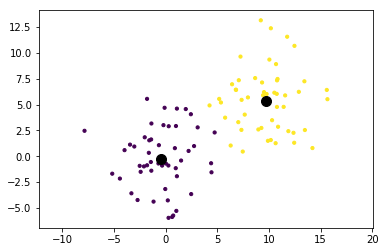

In [3]:
    np.random.seed(42)
    X = np.random.normal(size=(100,2), scale=3)
    X[50:] += (10, 5)

    model = FixedCovMixture(2, cov=[[3,0],[0,3]], random_state=1)
    model.fit(X)
    print(model.n_iter_, 'iterations')
    print(model.mean_)

    plt.scatter(X[:,0], X[:,1], s=10, c=model.predict(X))
    plt.scatter(model.mean_[:,0], model.mean_[:,1], s=100, c='k')
    plt.axis('equal')
    plt.show();

Если вы запускаете этот код в своём собственном Jupyter блокноте, вы можете увидеть, как центры кластеров постепенно смещаются в сторону своих финальных позиций. 

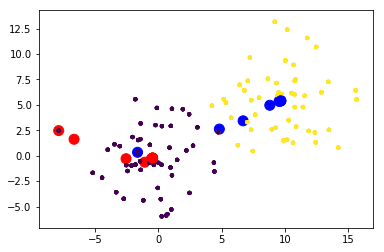

In [4]:
%matplotlib inline
import time
import pylab as pl
from IPython import display

model = FixedCovMixture(2, cov=[[3,0],[0,3]], random_state=1, max_iter=0)
model.fit(X)

for i in range(10):
    plt.scatter(X[:,0], X[:,1], s=10, c=model.predict(X))
    pl.scatter(model.mean_[:,0], model.mean_[:,1], s=100, c=['r', 'b'])
    model.mean_ = model.updated_centers(X)
    display.clear_output(wait=True)
    display.display(pl.gcf())
    time.sleep(0.3)
display.clear_output(wait=True);